In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# ==============================
# 📌 Step 1: Load CSV
# ==============================
file_path = r"D:\medical_billing_denial_analysis\data\data.csv"

# Skip the junk rows (first 2), use 3rd row as header
df = pd.read_csv(file_path, skiprows=2)

# Clean column names
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Drop "#" column if exists
if "#" in df.columns:
    df = df.drop(columns=["#"])

print("✅ Cleaned Columns:", df.columns.tolist())
print("✅ Data Shape:", df.shape)
print(df.head())


✅ Cleaned Columns: ['CPT_Code', 'Insurance_Company', 'Physician_Name', 'Payment_Amount', 'Balance', 'Denial_Reason']
✅ Data Shape: (26, 6)
   CPT_Code Insurance_Company Physician_Name Payment_Amount  Balance  \
0   99213.0          Medicare      Dr. Smith          $0.00  $100.00   
1   99214.0             Aetna    Dr. Johnson         $80.00   $20.00   
2   99215.0             Cigna        Dr. Lee          $0.00  $150.00   
3   93000.0  UnitedHealthcare      Dr. Patel         $50.00    $0.00   
4   99212.0        Blue Cross        Dr. Kim          $0.00   $75.00   

                      Denial_Reason  
0          16 - Missing information  
1                               NaN  
2  45 - Charge exceeds fee schedule  
3                               NaN  
4          96 - Non-covered service  


In [31]:
# Add a binary Denied flag
df["Denied"] = df["Denial_Reason"].notnull().astype(int)
print(df[["CPT_Code", "Insurance_Company", "Payment_Amount", "Balance", "Denial_Reason", "Denied"]].head())


   CPT_Code Insurance_Company Payment_Amount  Balance  \
0   99213.0          Medicare          $0.00  $100.00   
1   99214.0             Aetna         $80.00   $20.00   
2   99215.0             Cigna          $0.00  $150.00   
3   93000.0  UnitedHealthcare         $50.00    $0.00   
4   99212.0        Blue Cross          $0.00   $75.00   

                      Denial_Reason  Denied  
0          16 - Missing information       1  
1                               NaN       0  
2  45 - Charge exceeds fee schedule       1  
3                               NaN       0  
4          96 - Non-covered service       1  


In [33]:
cpt_summary = df.groupby("CPT_Code").agg(
    total_claims=("CPT_Code", "count"),
    denied_claims=("Denied", "sum")
).reset_index()

cpt_summary["denial_rate"] = (
    cpt_summary["denied_claims"] / cpt_summary["total_claims"] * 100
).round(2)

print("=== Top Denied CPT Codes ===")
print(cpt_summary.sort_values(by="denied_claims", ascending=False))


=== Top Denied CPT Codes ===
   CPT_Code  total_claims  denied_claims  denial_rate
1   99212.0             5              5        100.0
2   99213.0             5              5        100.0
4   99215.0             5              5        100.0
0   93000.0             5              0          0.0
3   99214.0             5              0          0.0


In [34]:
# By Payer
payer_breakdown = df.groupby(["Insurance_Company", "CPT_Code"]).agg(
    total_claims=("CPT_Code", "count"),
    denied_claims=("Denied", "sum")
).reset_index()
payer_breakdown["denial_rate"] = (
    payer_breakdown["denied_claims"] / payer_breakdown["total_claims"] * 100
).round(2)

print("=== Denial Breakdown by Payer ===")
print(payer_breakdown)

# By Physician
provider_breakdown = df.groupby(["Physician_Name", "CPT_Code"]).agg(
    total_claims=("CPT_Code", "count"),
    denied_claims=("Denied", "sum")
).reset_index()
provider_breakdown["denial_rate"] = (
    provider_breakdown["denied_claims"] / provider_breakdown["total_claims"] * 100
).round(2)

print("=== Denial Breakdown by Provider ===")
print(provider_breakdown)


=== Denial Breakdown by Payer ===
  Insurance_Company  CPT_Code  total_claims  denied_claims  denial_rate
0             Aetna   99214.0             5              0          0.0
1        Blue Cross   99212.0             5              5        100.0
2             Cigna   99215.0             5              5        100.0
3          Medicare   99213.0             5              5        100.0
4  UnitedHealthcare   93000.0             5              0          0.0
=== Denial Breakdown by Provider ===
  Physician_Name  CPT_Code  total_claims  denied_claims  denial_rate
0    Dr. Johnson   99214.0             5              0          0.0
1        Dr. Kim   99212.0             5              5        100.0
2        Dr. Lee   99215.0             5              5        100.0
3      Dr. Patel   93000.0             5              0          0.0
4      Dr. Smith   99213.0             5              5        100.0


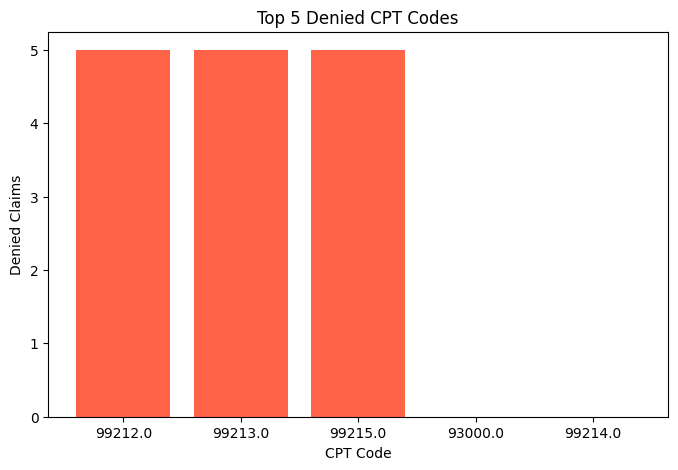

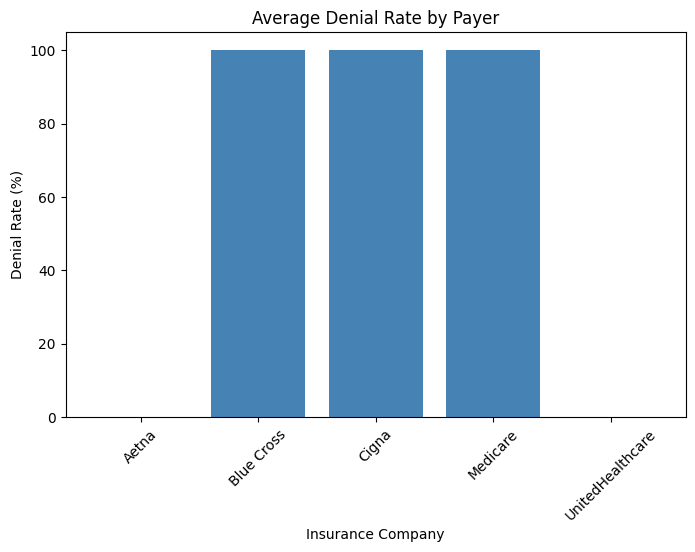

In [35]:
# Top 5 Denied CPTs
top_cpts = cpt_summary.sort_values(by="denied_claims", ascending=False).head(5)

plt.figure(figsize=(8,5))
plt.bar(top_cpts["CPT_Code"].astype(str), top_cpts["denied_claims"], color="tomato")
plt.title("Top 5 Denied CPT Codes")
plt.xlabel("CPT Code")
plt.ylabel("Denied Claims")
plt.show()

# Denial Rates by Insurance Company
payer_avg = payer_breakdown.groupby("Insurance_Company")["denial_rate"].mean().reset_index()

plt.figure(figsize=(8,5))
plt.bar(payer_avg["Insurance_Company"], payer_avg["denial_rate"], color="steelblue")
plt.title("Average Denial Rate by Payer")
plt.xlabel("Insurance Company")
plt.ylabel("Denial Rate (%)")
plt.xticks(rotation=45)
plt.show()


In [37]:
# ==============================
# Step 5: Root Cause Mapping
# ==============================
root_cause_map = {
    "16": "Lack of documentation",
    "45": "Fee schedule / Bundling edits (NCCI)",
    "96": "LCD/NCD mismatch",
}

# Extract denial code number from Denial_Reason (before "-")
df["Denial_Code"] = df["Denial_Reason"].str.extract(r"(\d+)")
df["Root_Cause"] = df["Denial_Code"].map(root_cause_map)

print("\nSample with Root Causes:")
print(df[["CPT_Code","Insurance_Company","Denial_Reason","Denial_Code","Root_Cause"]].head(10))

# Root causes by Payer
payer_root = df.groupby(["Insurance_Company","Root_Cause"]).size().reset_index(name="Count")
print("\n=== Root Causes by Payer ===")
print(payer_root)

# Root causes by CPT
cpt_root = df.groupby(["CPT_Code","Root_Cause"]).size().reset_index(name="Count")
print("\n=== Root Causes by CPT ===")
print(cpt_root)


Sample with Root Causes:
   CPT_Code Insurance_Company                     Denial_Reason Denial_Code  \
0   99213.0          Medicare          16 - Missing information          16   
1   99214.0             Aetna                               NaN         NaN   
2   99215.0             Cigna  45 - Charge exceeds fee schedule          45   
3   93000.0  UnitedHealthcare                               NaN         NaN   
4   99212.0        Blue Cross          96 - Non-covered service          96   
5   99213.0          Medicare          16 - Missing information          16   
6   99214.0             Aetna                               NaN         NaN   
7   99215.0             Cigna  45 - Charge exceeds fee schedule          45   
8   93000.0  UnitedHealthcare                               NaN         NaN   
9   99212.0        Blue Cross          96 - Non-covered service          96   

                             Root_Cause  
0                 Lack of documentation  
1                   

C:\Users\V.DHANUSH\AppData\Local\Temp\ipykernel_6692\3153871786.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Root_Cause", order=df["Root_Cause"].value_counts().index, palette="Set2")


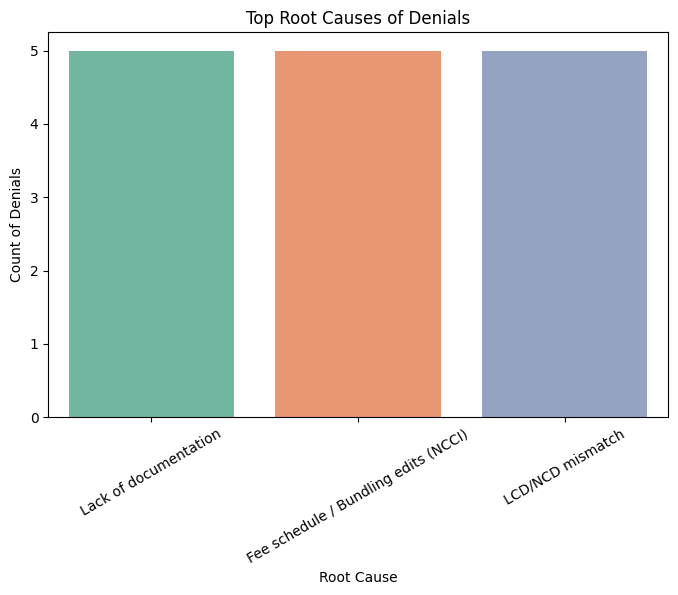

In [41]:
# ==============================
# Step 6: Visualization
# ==============================

import seaborn as sns

# --- Root Cause Distribution ---
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="Root_Cause", order=df["Root_Cause"].value_counts().index, palette="Set2")
plt.title("Top Root Causes of Denials")
plt.xlabel("Root Cause")
plt.ylabel("Count of Denials")
plt.xticks(rotation=30)
plt.show()

In [43]:
# ==============================
# Step 6: Recommendations
# ==============================
recommendation_map = {
    "Lack of documentation": [
        "Ensure required clinical documentation is attached before claim submission",
        "Train providers/front desk to capture all required info at point of service",
        "Use EHR prompts to reduce missing information"
    ],
    "Fee schedule / Bundling edits (NCCI)": [
        "Check CPT against payer’s fee schedule before billing",
        "Review NCCI bundling rules and avoid unbundled claims",
        "Use correct modifiers (e.g., -25, -59) when appropriate"
    ],
    "LCD/NCD mismatch": [
        "Verify coverage policies (LCD/NCD) before claim submission",
        "Confirm medical necessity and use appropriate ICD-10 codes",
        "If covered elsewhere, submit payer-specific appeal with supporting guidelines"
    ],
    "Prior authorization required": [
        "Track and obtain prior authorizations before service",
        "Implement a pre-service authorization checklist",
        "Educate scheduling/front desk staff on payer-specific prior auth rules"
    ],
    "Credentialing / Enrollment issue": [
        "Confirm provider is enrolled and credentialed with payer",
        "Update CAQH and payer rosters regularly",
        "Work with payer provider relations team to resolve credentialing issues"
    ]
}

def get_recommendations(root_cause):
    return recommendation_map.get(root_cause, ["Investigate further with payer-specific denial notes"])

# Attach recommendations
df["Recommendations"] = df["Root_Cause"].apply(get_recommendations)

# Explode so each recommendation is on its own row
rec_summary = df.explode("Recommendations")[["CPT_Code","Insurance_Company","Root_Cause","Recommendations"]]

print("\n=== Recommendations per CPT & Payer ===")
print(rec_summary.head(15))

# High-level payer strategies
payer_strategy = df.groupby(["Insurance_Company","Root_Cause"]).size().reset_index(name="Count")
payer_strategy["Recommended_Action"] = payer_strategy["Root_Cause"].map(
    lambda rc: "; ".join(recommendation_map.get(rc, ["Investigate further"]))
)

print("\n=== Payer-Specific Strategies ===")
print(payer_strategy)



=== Recommendations per CPT & Payer ===
   CPT_Code Insurance_Company                            Root_Cause  \
0   99213.0          Medicare                 Lack of documentation   
0   99213.0          Medicare                 Lack of documentation   
0   99213.0          Medicare                 Lack of documentation   
1   99214.0             Aetna                                   NaN   
2   99215.0             Cigna  Fee schedule / Bundling edits (NCCI)   
2   99215.0             Cigna  Fee schedule / Bundling edits (NCCI)   
2   99215.0             Cigna  Fee schedule / Bundling edits (NCCI)   
3   93000.0  UnitedHealthcare                                   NaN   
4   99212.0        Blue Cross                      LCD/NCD mismatch   
4   99212.0        Blue Cross                      LCD/NCD mismatch   
4   99212.0        Blue Cross                      LCD/NCD mismatch   
5   99213.0          Medicare                 Lack of documentation   
5   99213.0          Medicare       